# Distanzen der Punkte entlang von Scanlinien
Für die Angaben im Kap. 3. Bei einer repräsentativen Datei werden nur als Boden klassifizierte Punkte (mittels Cloth Simulation Filter, CSF) einer 10 x 10 m großen Fläche untersucht. Es werden jeweils die Distanzen zu den 2 nächsten Nachbarn betrachtet, soweit diese unter einem Schwellenwert von 0,07 m liegen.

In [1]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import os
import json
from scipy.spatial import cKDTree
from interessant import * # Bei Änderungen Kernel neu starten

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [12]:
# Gewählte Datei

run = run24
key = list(interessant.keys())[0] 
filename = interessant[key]
print(key, filename)

filename = os.path.join(run, filename)
if not os.path.exists(filename):
    raise FileNotFoundError(filename)

Einfach 4473900_5335875.copc.laz


Öffne Datei, klassifiziere Bodenpunkte mit Cloth Simulation Filter (CSF) und behalte nur Boden

In [3]:
pipeline = pdal.Pipeline([pdal.Reader(filename)]) | pdal.Filter.csf() | pdal.Filter.range(limits='Classification[2:2]') 

pipeline.execute()
points = pipeline.arrays[0]

In [4]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
offset = xyz.mean(axis=0)
xyz -= offset

xyz.shape

(1222874, 3)

Subset aus zentralem Bereich der Datei

In [5]:
mask = (xyz[:, 0] > -5) & (xyz[:, 0] < 5) & (xyz[:, 1] > -5) & (xyz[:, 1] < 5) 
xyz = xyz[mask]
xyz.shape

(415747, 3)

Verwende k-d-Baum, um nächste Nachbarn zu finden

In [6]:
tree = cKDTree(xyz)

# Distanzen zu 3 nächsten Nachbarn (der Punkt selbst + 2 nächste)
distances, _ = tree.query(xyz, k=3)

# distances[:, 0] ist immer 0 (Distanz zum Punkt selbst), daher entfernen
nn1 = distances[:, 1]  # Distanz zum 1. nächsten Nachbarn
nn2 = distances[:, 2]  # Distanz zum 2. nächsten Nachbarn

Einfache Statistik zu erstem und zweitem nächsten Nachbarn, noch ohne Schwellenwert auf Distanz

In [ ]:
print("First Nearest Neighbor Distance:")
print(f"  Mean: {np.mean(nn1):.4f}, Std: {np.std(nn1):.4f}, Min: {np.min(nn1):.4f}, Max: {np.max(nn1):.4f}")
print("Second Nearest Neighbor Distance:")
print(f"  Mean: {np.mean(nn2):.4f}, Std: {np.std(nn2):.4f}, Min: {np.min(nn2):.4f}, Max: {np.max(nn2):.4f}")


First Nearest Neighbor Distance:
  Mean: 0.0068, Std: 0.0041, Min: 0.0002, Max: 0.4347
Second Nearest Neighbor Distance:
  Mean: 0.0094, Std: 0.0057, Min: 0.0022, Max: 0.4377


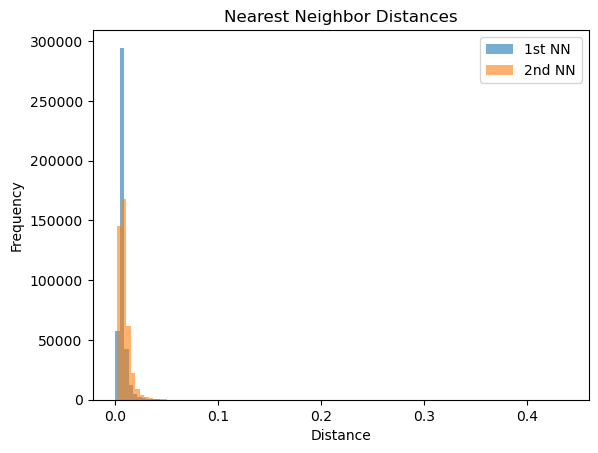

In [8]:
plt.hist(nn1, bins=100, alpha=0.6, label='1st NN')
plt.hist(nn2, bins=100, alpha=0.6, label='2nd NN')
plt.legend()
plt.title("Nearest Neighbor Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

Statistik mit Schwellenwert auf Distanz (Distanzen zu erstem und zweitem Nachbarn kombiniert)

Basic statistics after filtering:
  Mean: 0.0081, Median: 0.0065, Std: 0.0048, Min: 0.0002, Max: 0.0700


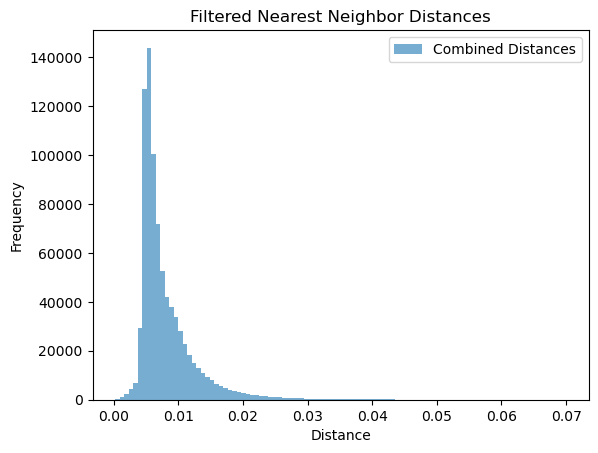

In [13]:
# Schwellenwert auf Distanz
threshold = 0.07

# Filter nach Schwellenwert
nn1_filtered = nn1[nn1 <= threshold]
nn2_filtered = nn2[nn2 <= threshold]

# Zu einem Array kombinieren
combined_distances = np.concatenate([nn1_filtered, nn2_filtered])

print("Basic statistics after filtering:")
print(f"  Mean: {np.mean(combined_distances):.4f}, Median: {np.median(combined_distances):.4f}, Std: {np.std(combined_distances):.4f}, Min: {np.min(combined_distances):.4f}, Max: {np.max(combined_distances):.4f}")
plt.hist(combined_distances, bins=100, alpha=0.6, label='Combined Distances')
plt.legend()
plt.title("Filtered Nearest Neighbor Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

Visualisierung mit Open3D

In [14]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

cmap = plt.get_cmap("viridis")
distance_normalized = nn1 / threshold
distance_normalized = np.clip(distance_normalized, 0, 1)
colors = cmap(distance_normalized)[:, :3]  # Get RGB values from colormap, ignoring alpha channel
pcd.colors = o3d.utility.Vector3dVector(colors)
colors[nn1 > threshold] = [1, 0, 0]  # Red for points outside threshold

axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0])

o3d.visualization.draw_geometries([pcd, axes])
